In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import center_of_mass

In [2]:
cases_admiss = {}
admiss_occup = {}

In [3]:
# download api data
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=hospitalCases&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json" #&release=2021-06-02"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df = pd.DataFrame(response['body'])
df['dateTime'] = pd.to_datetime(df['date'])
df.sort_values(by=['dateTime'], inplace=True)
df.dropna(inplace=True)

x_dateTimes = sorted(list(set(df.dateTime.to_list())))
top_date = x_dateTimes[-1].strftime("%Y-%m-%d")
print(top_date)

2021-06-16


In [4]:
waves = [
    {"start":"2020-08-01", "end":top_date},    
    {},
    {"start":"2020-08-01", "end":"2021-05-01"},    
    {"start":"2021-04-01", "end":top_date}
]

wave = 2
start_date = waves[wave]["start"]
end_date = waves[wave]["end"]

_df = df[(df.dateTime >= start_date) & (df.dateTime <= end_date)]
cases_stream = np.array(_df.newCasesBySpecimenDate.to_list(), dtype=int)
admissions_stream = np.array(_df.newAdmissions.to_list(), dtype=int)
occupancy_stream = np.array(_df.hospitalCases.to_list(), dtype=int)
#occupancy_stream -= occupancy_stream[0]

def N_avg(a, N=7):
    # weekly avg into the past
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

#cases_stream = N_avg(cases_stream)
#admissions_stream = N_avg(admissions_stream)
#occupancy_stream = N_avg(occupancy_stream)

print(cases_stream)
print(admissions_stream)
print(occupancy_stream)
print(len(occupancy_stream))

[  494   513   938   920   941   980   867   635   555  1350  1211  1095
  1020  1038   643   530  1136   925  1072  1218  1007   715   696  1131
  1060  1137  1325  1382  1041   976  1261  1928  2617  2664  2591  2189
  2056  3463  2999  2853  3100  2854  2206  1708  2896  3038  3742  3938
  4275  4179  4624  4698  5361  5889  6293  6034  5650  6023  8580  8719
 10520 11301 11576  9703  9834 14034 14295 15193 15264 13012 10151  9652
 16191 15433 16445 15242 14547 12352 11855 22101 21338 21483 19617 18107
 13517 13165 22753 20486 20229 19978 19644 14350 13369 27927 22307 20694
 20877 20829 16620 17963 28095 24464 24642 21945 21651 16035 14209 23726
 20320 18218 15505 14677 10615 10038 16204 14030 13932 12277 12263  9208
  8906 15030 13515 13465 12526 12884 10143 10870 17394 16672 17459 18546
 19866 16030 18128 29521 29095 30124 29595 31832 21733 28940 42590 40899
 37617 28699 12675 36704 42440 40043 72507 62898 46679 28221 54167 49514
 69109 58039 51315 46827 42334 35443 32858 51997 44

In [5]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=cases_stream, out_stream=admissions_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [6]:
n_dim = 30
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = np.zeros(n_dim)
options = {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([x_min for i in range(n_particles)])

outputs = []

In [7]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    outputs.append(pos)

2021-06-19 17:23:17,426 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=117 
2021-06-19 17:23:22,933 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 116.7972560741909, best pos: [0.01391555 0.00387202 0.00201055 0.00497005 0.0021569  0.00755858
 0.00967782 0.00240746 0.00239606 0.00210665 0.00149945 0.00307499
 0.00102552 0.00317175 0.00099575 0.00287947 0.0010827  0.00132439
 0.00125393 0.00096707 0.00115185 0.00073329 0.00208183 0.00238149
 0.00062467 0.00107495 0.00117526 0.00120548 0.00079081 0.00206577]
2021-06-19 17:23:22,940 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=122 
2021-06-19 17:23:28,521 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 121.8740116529459, best pos: [0.01259743 0.0046

2021-06-19 17:24:30,209 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=118 
2021-06-19 17:24:36,250 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 117.92917776163593, best pos: [0.01078338 0.00762091 0.00119463 0.00252209 0.00203055 0.00875364
 0.00563946 0.00826865 0.00207013 0.0019143  0.00245055 0.0013632
 0.00158163 0.00250013 0.00101949 0.00210812 0.00198777 0.00204778
 0.00211776 0.00076804 0.00208501 0.00110725 0.00090629 0.00168329
 0.00091144 0.00126567 0.00088965 0.00154089 0.00137682 0.00100435]
2021-06-19 17:24:36,257 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=118 
2021-06-19 17:24:41,853 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 117.84784060204761, best pos: [0.01378552 0.002

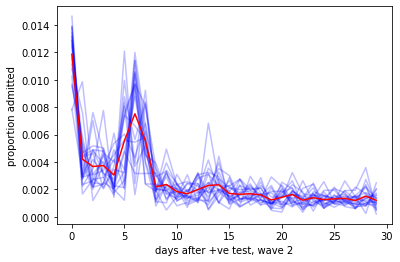

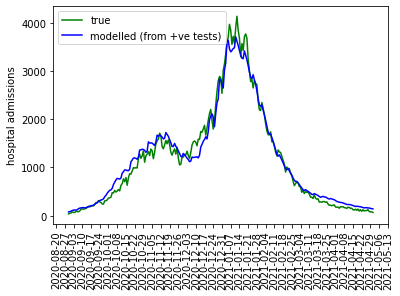

In [8]:
_outputs = np.array(outputs)
plt.clf()
x = list(range(len(pos)))
for y in _outputs:
    #print(sum(y))
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg = []
for i in range(len(y)):
    y_avg.append(np.mean(_outputs[:,i]))
plt.plot(x, y_avg, color="red", alpha=1)
plt.xlabel("days after +ve test, wave %d" % wave)
plt.ylabel("proportion admitted")
plt.savefig("cases_admiss_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _f(np.array(y_avg), cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled (from +ve tests)")
#plt.xlabel("days after start of wave %d" % wave)
plt.ylabel("hospital admissions")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

cases_admiss[wave] = y_avg

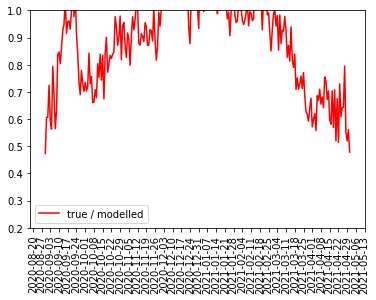

In [9]:
plt.clf()
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="true / modelled")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.ylim(0.2,1)
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()


2 0.08132840081404467 (7.958040131031457,)


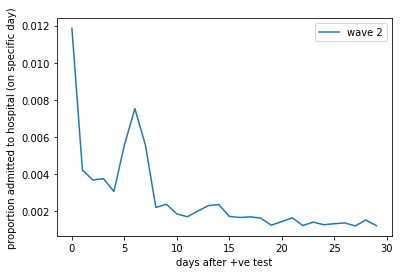

In [10]:
for wave,y_avg in cases_admiss.items():
    print(wave, np.sum(y_avg), center_of_mass(np.array(y_avg[:25])))
          
plt.clf()
x = range(n_dim)
for wave,y_avg in cases_admiss.items():
    plt.plot(x, y_avg, label="wave %d" % wave)
plt.xlabel("days after +ve test")
plt.ylabel("proportion admitted to hospital (on specific day)")
plt.legend()
plt.savefig("cases_admiss_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

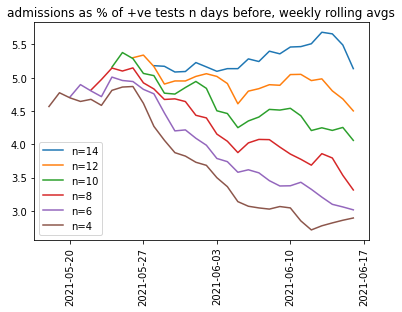

In [11]:
x_dateTimes = df.dateTime.to_list()[-len(x)-11:]

y = {}
admiss_rolling = {}
cases_rolling = {}
for n in [14,12,10,8,6,4]:
    _y1 = []
    _y2 = []
    _y = []
    for dateTime in x_dateTimes[n+7:]:
        dateTime1 = dateTime - datetime.timedelta(days=8)
        dateTime2 = dateTime 
        y1 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newAdmissions.to_list())
        _y1.append(y1/7)
        dateTime1 = dateTime1 - datetime.timedelta(days=n)
        dateTime2 = dateTime2 - datetime.timedelta(days=n)
        y2 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newCasesBySpecimenDate.to_list())
        _y2.append(y2/7)
        _y.append(y1/y2)
    y[n] = np.array(_y)
    admiss_rolling[n] = np.array(_y1)
    cases_rolling[n] = np.array(_y2)

plt.clf()
plt.title("admissions as % of +ve tests n days before, weekly rolling avgs")
for n,_y in y.items():
    plt.plot(x_dateTimes[n+7:], _y*100, label="n=%d" % n)
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
#plt.ylim(2,None)
plt.legend()
plt.savefig("test_vs_admiss_n_days_ago", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()



In [12]:
def _g(x, in_stream, out_stream):
    # model each 1 from in_stream as remaining present for a period with distribution x, in out_stream
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def g(xs, in_stream=admissions_stream, out_stream=occupancy_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _g(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret    

print(_g(np.array([0.5,0.5]), [1,1,1,3,3,3], [0,1,2,3,4,5]))

([1, 2, 3, 4, 5], array([1., 1., 2., 3., 3.]))


In [13]:
n_dim = 30
n_particles = 1000

x_max = np.ones(n_dim)
x_max[0:3] = [1.1,1.1,1.1]
x_min = -0.1*np.ones(n_dim)
options = {'c1': 0.6, 'c2': 0.3, 'w': 0.90}
bounds = (x_min, x_max)
init_pos = None#np.array([x_min for i in range(n_particles)])

outputs = []

In [14]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=11)
    outputs.append(pos)

2021-06-19 17:25:12,851 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=375
2021-06-19 17:25:18,973 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 375.1198891200958, best pos: [ 0.9502564   0.98779822  0.87995444  0.47499965  0.50286732  0.4793035
  0.67886706  0.66454895  0.45972093  0.1815435   0.0234484   0.57553891
  0.57941258  0.11197519  0.02696344  0.20318672  0.2358189   0.11277967
 -0.08828426  0.54222821  0.00151328  0.17088563  0.07292704  0.29029565
  0.02227796  0.52513179  0.13169293  0.12630874 -0.05149905 -0.01371034]
2021-06-19 17:25:18,981 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=377 
2021-06-19 17:25:25,004 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 376.7213279302053, 

2021-06-19 17:26:27,306 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=353
2021-06-19 17:26:33,600 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 353.22810586503186, best pos: [ 1.08241422  0.53004795  0.57600827  0.9332887   0.75981382  0.73853896
  0.49703901  0.80331027  0.4749744   0.40906898  0.1287191   0.34909601
  0.40219226  0.0618998   0.09423469  0.04995023  0.01894297  0.03618668
  0.05651444  0.06094727  0.27412596  0.17521263  0.29389463 -0.04492267
  0.29669624  0.03340703  0.10761458 -0.08264929  0.35490166  0.3492362 ]
2021-06-19 17:26:33,608 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=358
2021-06-19 17:26:39,995 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 357.6893892357919,

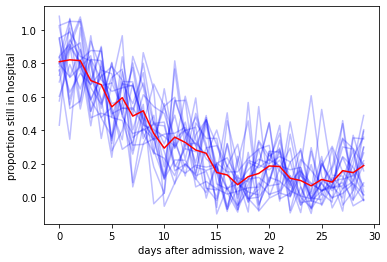

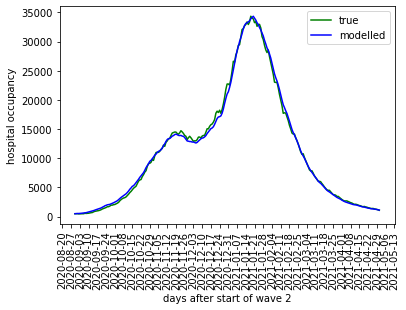

In [15]:
_outputs = np.array(outputs)
plt.clf()
x = list(range(len(pos)))
for y in _outputs:
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg = []
for i in range(len(y)):
    y_avg.append(np.mean(_outputs[:,i]))
plt.plot(x, y_avg, color="red", alpha=1)
plt.xlabel("days after admission, wave %d" % wave)
plt.ylabel("proportion still in hospital")
plt.savefig("admiss_occup_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _g(np.array(y_avg), admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled")
plt.xlabel("days after start of wave %d" % wave)
plt.ylabel("hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

admiss_occup[wave] = y_avg

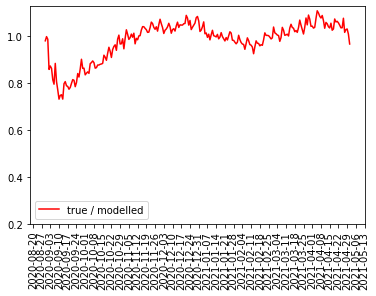

In [16]:
plt.clf()
true, pred = _g(admiss_occup[2], admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="true / modelled")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.ylim(0.2,None)
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

2 9.834713862102328 (8.764738834542593,)


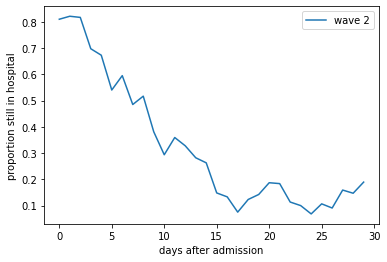

In [17]:
for wave,y_avg in admiss_occup.items():
    print(wave, np.sum(y_avg), center_of_mass(np.array(y_avg)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg in admiss_occup.items():
    plt.plot(x, y_avg, label="wave %d" % wave)
plt.xlabel("days after admission")
plt.ylabel("proportion still in hospital")
plt.legend()
plt.savefig("admiss_occup_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()